In [6]:
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt


from scipy.signal import butter, filtfilt, iirnotch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def bw_bandpass(data, lowcut, highcut, fs, order = 2):
    nyquist = fs * 0.5
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype = 'band', output = 'ba', analog = False)
    return filtfilt(b, a, data, axis = 1)

def bw_notch5060(data, fs, order = 2):
    nyquist = fs * 0.5
    bp50 = np.array([49.0, 51.0]) / nyquist
    bp60 = np.array([59.0, 61.0]) / nyquist

    b, a = butter(order, bp50, btype = 'bandstop', output = 'ba', analog = False)
    data = filtfilt(b, a, data, axis = 1)

    b, a = butter(order, bp60, btype = 'bandstop', output = 'ba', analog = False)
    data = filtfilt(b, a, data, axis = 1)
    return data

#read trajectory data
def resample(data, target_length):
    ori_indices = np.arange(len(data))
    new_indices = np.linspace(0, len(data) - 1, target_length)
    return np.interp(new_indices, ori_indices, data)

def split_to_chunks(ts, eeg, pre_len, post_len):
    chunks = np.array([])
    for t in ts:
        sample_chunk = np.expand_dims(eeg[:, t[0] - pre_len:t[0] + post_len], 0)
        chunks = np.concatenate([chunks, sample_chunk], 0) if chunks.size else sample_chunk
    
    return chunks

def preprocess(eeg, high_cut, low_cut, notch = True, sfreq = 125, order = 2):
    balanced_signal = eeg - np.mean(eeg)
    #normalize
    scaler = MinMaxScaler(clip=True)

    if notch:
        filtered = bw_notch5060(balanced_signal, sfreq)
        butterworth = bw_bandpass(filtered, high_cut , low_cut, sfreq, order)
    else:
        butterworth = bw_bandpass(balanced_signal, high_cut , low_cut, sfreq, order)
    
    butterworth = scaler.fit_transform(butterworth)
    return butterworth

#CUE and ending time = 2s and 1s respectively

# Angualr resampled
RESAMPLE_SIZE = 20
# angs_path = os.path.join(os.getcwd(), 'CapiLab-dataset3' ,'sgym_040723','*ANGLE*') #repalce to the directory
angs_path = os.path.join(os.getcwd(), 'outputs','*ANGLE*') #repalce to the directory
angs_files = glob(angs_path)
# EEG chunk division
eegs_path = os.path.join(os.getcwd(), 'outputs','*EEG*') #repalce to the directory
eegs_files = glob(eegs_path)

angs = np.array([])
timestamp = np.array([])
eegs = np.array([])


sfreq = 125
offset_time = (2 * sfreq)

selected_files = []

for i, (fa,fe)  in enumerate(zip(angs_files, eegs_files)):
    #extract angular data and associate timestamp
    tmp_a = np.load(fa)
    ang = np.expand_dims(resample(tmp_a[:,0], RESAMPLE_SIZE), [0,-1])
    ts = np.expand_dims(resample(tmp_a[:,1], RESAMPLE_SIZE),[0, -1])
    ts = (ts - ts.min()) * 10**-9 #$time stamp is in nano second
    if 1.85 <= ts.max() - ts.min() <= 2.15: #filter only feasible trajectories
        angs = np.concatenate([angs, ang], axis = 0) if angs.size else ang
        timestamp = np.concatenate([timestamp, ts], axis = 0) if timestamp.size else ts

        #using timestamp to split EEG into chunks
        tmp_e = np.load(fe)[2:18,:]
        tmp_e = preprocess(tmp_e, 0.1, 12)
        #convert to index loc
        index_loc = np.round(timestamp[-1] * sfreq).astype(np.int32) + (offset_time)
        chunk = split_to_chunks(index_loc, tmp_e, 16, 16)
        eeg_chunk = np.expand_dims(chunk, 0)
        eegs = np.concatenate([eegs, eeg_chunk], 0) if eegs.size else eeg_chunk

        selected_files.append(fa)

import random
# extract test data
subjs = ['CHI', 'DLC', 'SGMT', 'LYF']
test_target = []
for subj in subjs:
    loc = [i for i, l in enumerate(selected_files) if l.find(subj) != -1]
    random.shuffle(loc)
    test_target += loc[:3]

del angs_files, angs_path, eegs_files, eegs_path
print(eegs.shape)
# TRAIN and VALIDATION DATA

eX = np.array([])
veX = np.array([])


vaX = angs[test_target, :, :]
veX = eegs[test_target, :, :, :]
vtX = timestamp[test_target, :, :]

aX = np.delete(angs, test_target, axis = 0)
eX = np.delete(eegs,test_target, axis = 0)
tX = np.delete(timestamp,test_target, axis = 0)

print(vaX.shape, veX.shape, vtX.shape, aX.shape, eX.shape, tX.shape)

(109, 20, 16, 32)
(12, 20, 1) (12, 20, 16, 32) (12, 20, 1) (97, 20, 1) (97, 20, 16, 32) (97, 20, 1)


In [7]:
ts_scaler = MinMaxScaler()
ori_dim = timestamp.shape
timestamp_norm = timestamp.reshape(ori_dim[0], ori_dim[1] * 1)
timestamp_norm = ts_scaler.fit_transform(timestamp_norm)
timestamp_norm = np.expand_dims(timestamp_norm, -1)
timestamp_norm.shape

(109, 20, 1)

(20, 16, 32)
(20, 512)


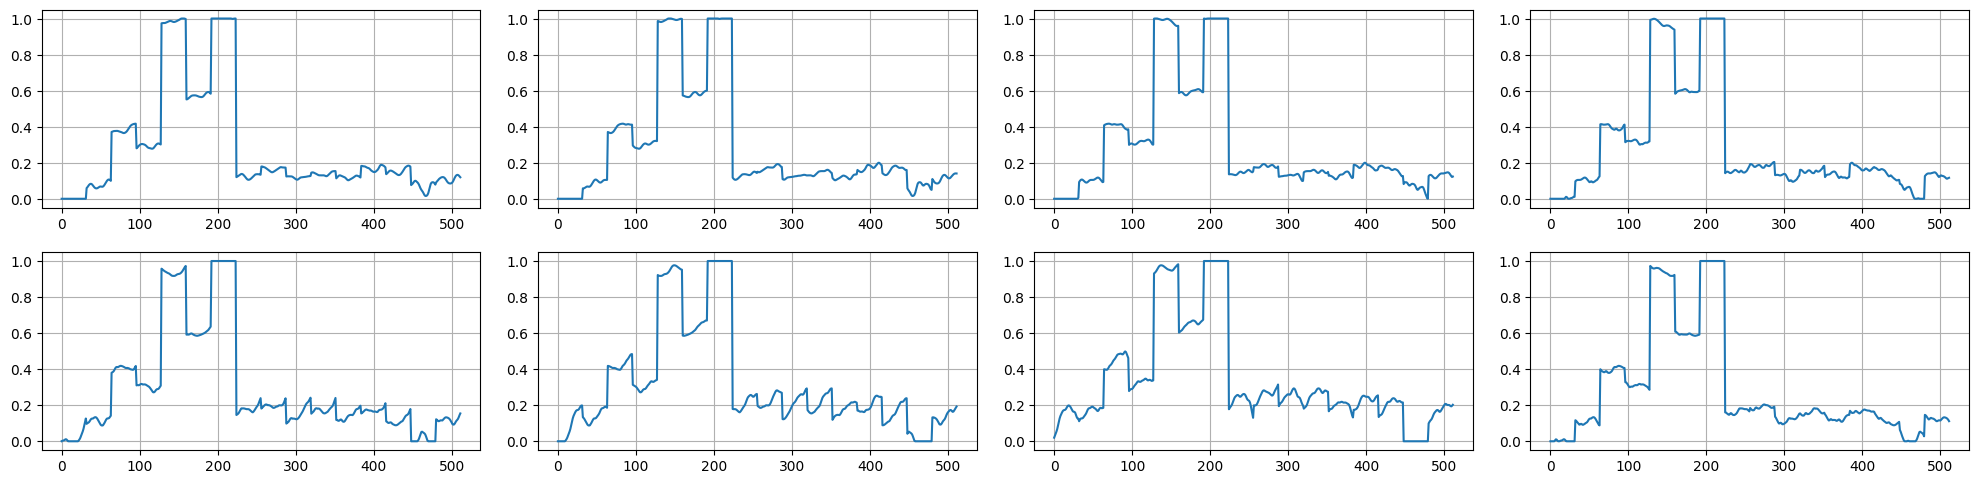

In [17]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,4, figsize = (20,5))
fig.tight_layout()
plot_eX = eX[np.random.randint(0, len(eX)),:,:, :]
ori = plot_eX.shape
print(ori)
flatten_eX = plot_eX.reshape(ori[0], ori[1] * ori[2])
print(flatten_eX.shape)
for i in range(8):
    if i < 4:
        # axs[0][i].plot(plot_eX[i,:,:].flatten().T, 'o')
        axs[0][i].plot(flatten_eX[i].T)
        axs[0][i].grid()
    else:
        axs[1][i - 5].plot(plot_eX[i,:,:].flatten().T)
        axs[1][i - 5].grid()
plt.show()




In [18]:
def get_train_sample(eeg_data, angular_data, obs_max, time_len):

    d = np.random.randint(0, eeg_data.shape[0])
    n = np.random.randint(0,obs_max) + 1 #number of sampled
    times = np.linspace(0,1,time_len)
    perm = np.random.permutation(time_len)


    train_eeg = eeg_data[d].copy()
    ori = train_eeg.shape
    train_eeg = train_eeg.reshape(ori[0], ori[1] * ori[2])

    train_ang = angular_data[d].copy()

    #training data buffer
    observation_eeg = np.zeros((1,n,512,2)) 
    observation_ang = np.zeros((1,n,2)) 
    target_T = np.zeros((1,1))
    target_eX = np.zeros((1,1024))
    target_aX = np.zeros((1,2))

    for i in range(n):
        observation_eeg[0,i, :, 0] = np.ones((1, 512)) * times[perm[i]]
        observation_eeg[0,i, :, 1] = train_eeg[perm[i]]
        observation_ang[0, i, 0] = times[perm[i]]
        observation_ang[0, i, 1] = train_ang[perm[i]]

    target_T[0, 0] = times[perm[i]]
    target_eX[0, :512] = train_eeg[perm[i]]
    target_aX[0, :1] = train_ang[perm[i]]

    return [observation_eeg, observation_ang, target_T], [target_eX, target_aX], d, perm[n]


def get_test_sample():
    pass


# inp, opt, _, _ = get_train_sample(eX, aX, RESAMPLE_SIZE - 2, RESAMPLE_SIZE)


In [19]:
import os
import tensorflow as tf
import keras
from keras.layers import Add,Multiply,Softmax,Input,TimeDistributed,Dense,Average,GlobalAveragePooling1D,Concatenate,Lambda,RepeatVector, Conv2D,ConvLSTM2D, MaxPooling2D,BatchNormalization,Flatten,Reshape,UpSampling2D
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import pylab as pl
from IPython import display
from IPython.core.display import HTML
from IPython.core.display import display as html_width
html_width(HTML("<style>.container { width:90% !important; }</style>"))
import tensorflow_probability as tfp
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec
import imageio
from tqdm import tqdm
from keras.utils.vis_utils import plot_model


import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
import tensorflow_probability as tfp
tf.keras.saving.get_custom_objects().clear()

@tf.keras.saving.register_keras_serializable(package="CustomLoss", name='custom_loss')
def custom_loss(y_true, y_predicted):
    mean, log_sigma = tf.split(y_predicted, 2, axis=-1)
    y_true_value, temp =tf.split(y_true,2,axis=-1)
    sigma = tf.nn.softplus(log_sigma)
    dist = tfp.distributions.MultivariateNormalDiag(loc=mean, scale_diag=sigma)
    loss = -tf.reduce_mean(dist.log_prob(y_true_value))
    return loss


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, TimeDistributed, Conv2D, MaxPooling2D, Multiply, Add,
                                     Flatten, Dense, GlobalAveragePooling1D, Reshape, UpSampling2D, Concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

eeg_layer = Input(shape=(None, 513), name = 'EEG observation layer')
ang_layer = Input(shape=(None, 2), name = 'Angular Observation layer')
target_t_layer = Input(shape=(1,), name = 'Target query time')

############ ENCODER -----------------------------------------------------------
# EEG Layer - encoder with down sampling
eeg_encoder = TimeDistributed(Dense(256, activation = 'relu'))(eeg_layer)
eeg_encoder = TimeDistributed(Dense(128, activation = 'relu'))(eeg_encoder)
eeg_encoder = TimeDistributed(Dense(64, activation = 'relu'))(eeg_encoder)
eeg_encoder = TimeDistributed(Dense(32, activation = 'relu'))(eeg_encoder)
eeg_encoder = TimeDistributed(Dense(16, activation = 'relu'))(eeg_encoder)
eeg_encoder = TimeDistributed(Dense(8, activation = 'relu'))(eeg_encoder)
eeg_representation = GlobalAveragePooling1D()(eeg_encoder) 

# ANG Layer - upsampling to have the same size as EEG latens
ang_encoder = TimeDistributed(Dense(2, activation = 'relu'))(ang_layer)
ang_encoder = TimeDistributed(Dense(4, activation = 'relu'))(ang_encoder)
ang_encoder = TimeDistributed(Dense(8, activation = 'relu'))(ang_encoder)
ang_representation = GlobalAveragePooling1D()(ang_encoder) 
############ GENERAL -----------------------------------------------------------
general_representation = Add()([eeg_representation, ang_representation])
merged_layer = Concatenate(axis=-1, name='merged')([general_representation, target_t_layer])

############ DECODER -----------------------------------------------------------
# EEG Layer - upsampling decoder
eeg_decoder = Dense(8, activation = 'relu')(merged_layer)
eeg_decoder = Dense(16, activation = 'relu')(eeg_decoder)
eeg_decoder = Dense(32, activation = 'relu')(eeg_decoder)
eeg_decoder = Dense(64, activation = 'relu')(eeg_decoder)
eeg_decoder = Dense(128, activation = 'relu')(eeg_decoder)
eeg_decoder = Dense(256, activation = 'relu')(eeg_decoder)
eeg_decoder = Dense(512, activation = 'relu')(eeg_decoder)
eeg_out     = Dense(1024, activation = 'relu', name = 'EEG-output')(eeg_decoder) 

# ANG Layer - downsampling decoder
ang_decoder = Dense(8, activation = 'relu')(merged_layer)
ang_decoder = Dense(4, activation = 'relu')(ang_decoder)
ang_out     = Dense(2, name = 'Angular-output')(ang_decoder)


model = Model([eeg_layer, ang_layer, target_t_layer],[eeg_out,ang_out])
# latent_model = Model([image_layer, joint_layer, target_X_layer, img_coef_layer, pose_coef_layer],general_representation)
model.compile(optimizer = Adam(learning_rate= 1e-3),loss=custom_loss, loss_weights=[1,0.01])
# model.summary()
plot_model(model)

In [505]:
from tensorflow.keras.callbacks import ModelCheckpoint
import gc
# checkpoint_save = 10000
checkpoint = ModelCheckpoint('checkpoint/', save_best_only = True, monitor = 'loss')

loss_checkpoint = 1000
plot_checkpoint = 1000
validation_checkpoint = 1000
validation_error = 9999999
validation_step = -1
max_training_step = 2000000

float_formatter = "{:.4f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

for step in range(max_training_step):
    inp, out, _, _ = get_train_sample(eX, aX, RESAMPLE_SIZE - 2, RESAMPLE_SIZE)
    callback = model.fit(inp,out)
    gc.collect()
    '''
    if step % validation_checkpoint == 0:
        pass
    '''
    if step % plot_checkpoint == 0:
        if step != 0:
            model.save(f'model_at_step_{step + 1}')
    tensorflow.keras.backend.clear_session()


ModuleNotFoundError: No module named 'tensorflow'